In [3]:
import numpy as np
import scipy
from scipy.linalg import lu_factor, lu_solve
from scipy.linalg import qr, solve_triangular
import matplotlib as mpl
import matplotlib.pyplot as plt
import bspy

# ODE \#2

$$y''(t)=y(t),\qquad y(0)=1,\quad y(1)=1$$

knots: [0.   0.   0.   0.   0.   0.25 0.5  0.75 1.   1.   1.   1.   1.  ]
t: 0.0 index: 5 second deriv bval: [ 192. -288.   96.    0.    0.] bval: [1. 0. 0. 0. 0.]
t: 0.2 index: 5 second deriv bval: [  7.68        19.2        -40.53333333   8.53333333   5.12      ] bval: [0.0016     0.256      0.52622222 0.19911111 0.01706667]
t: 0.4 index: 6 second deriv bval: [  3.84         9.38666667 -22.18666667   5.12         3.84      ] bval: [0.0032     0.20382222 0.54151111 0.24426667 0.0072    ]
t: 0.6000000000000001 index: 7 second deriv bval: [  3.84         5.12       -22.18666667   9.38666667   3.84      ] bval: [0.0072     0.24426667 0.54151111 0.20382222 0.0032    ]
t: 0.8 index: 8 second deriv bval: [  5.12         8.53333333 -40.53333333  19.2          7.68      ] bval: [0.01706667 0.19911111 0.52622222 0.256      0.0016    ]
t: 1.0 index: 8 second deriv bval: [   0.    0.   96. -288.  192.] bval: [0. 0. 0. 0. 1.]


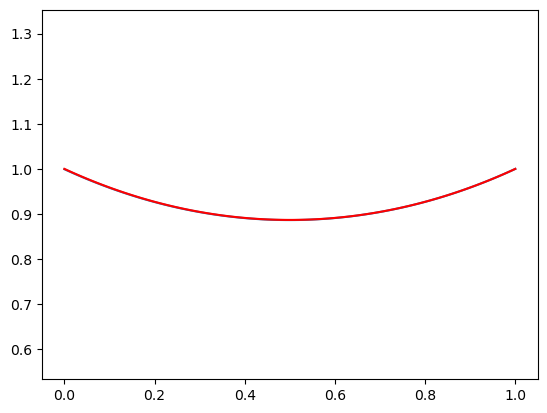

In [9]:
#set parameters

degree = 4
nknots = 3 #interior knots


#create knot vector

knots = np.linspace(0.0, 1.0, nknots + 2)
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]]) # add extra knots at beginning and end
print("knots:", knots)


#initialize order and dimension

order = degree + 1
n = len(knots) - order #dimension
#print("dimensions:", n)


collocationpoints = np.linspace(0.0, 1.0, n - 2) # n-2 due to 2 given points
#print("collocation points:", collocationpoints)


#initialize collocation matrix

collocation = np.zeros((n, n))
#print("initialized collocation array:", collocation)

#find index of first knot in the array that follows point of evaluation, set Bslipne boundary condition to 1.0 
ix = np.searchsorted(knots, 1.0, side = 'right')
ix = min(ix, n)
#print("index:", ix)


#fill collocation matrix with Bspline values at 1.0
bvalues = bspy.Spline.bspline_values(ix, knots, order, 1.0)
collocation[-1, ix - order : ix] = bvalues


#find index of first knot in the array that follows point of evaluation, set Bslipne boundary condition to 1.0 
ix = np.searchsorted(knots, 1.0, side = 'right')
ix = min(ix, n)
#print("index:", ix)


#fill collocation matrix with Bspline values at 0.0
bvalues = bspy.Spline.bspline_values(ix, knots, order, 0.0)
collocation[0, ix - order : ix] = bvalues


for irow, t in enumerate(collocationpoints):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)

    #calculate Bspline and derivative at t
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    bvalues2p = bspy.Spline.bspline_values(ix, knots, order, t, 2)
    print("t:", t,"index:", ix, "second deriv bval:", bvalues2p, "bval:", bvalues)
    
    #from the irow value after boundary condition (irow) insert y'' - y
    collocation[irow + 1, ix - order : ix] = bvalues2p - bvalues 
    #print("collocation:", collocation)
    
# Create the right hand side
rhs = np.zeros((n,))
rhs[-1] = 1.0
rhs[0] = 1.0
#print("rhs:", rhs)

# Solve the linear system
lupiv = scipy.linalg.lu_factor(collocation)
alpha = scipy.linalg.lu_solve(lupiv, rhs)
alpha

#create spline function
u = bspy.Spline(1, 1, [order], [n], [knots], [alpha])
u(0.0), u(0.5), u(1.0)

#print("collocation", collocation, "*", "alpha", alpha, "=", "rhs", rhs)


#plot
plt.plot(*u.graph()(np.linspace(0.0,1.0,101)))
tvals = np.linspace(0, 1, 100)
plt.plot(tvals, (np.exp(tvals) + np.exp(-tvals + 1))/(1 + np.exp(1)), 'r')
plt.axis('equal')
plt.show()